In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 95% 316M/331M [00:00<00:00, 719MB/s] 
100% 331M/331M [00:00<00:00, 797MB/s]


In [6]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [7]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [9]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [10]:
len(age),len(gender),len(img_path)

(23708, 23708, 23708)

In [11]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [12]:
df.shape

(23708, 3)

In [13]:
df.head()

,age,gender,img
0,67,1,67_1_0_20170120224807800.jpg.chip.jpg
1,53,1,53_1_0_20170110160643297.jpg.chip.jpg
2,69,1,69_1_0_20170110141630303.jpg.chip.jpg
3,78,0,78_0_0_20170111210454101.jpg.chip.jpg
4,30,1,30_1_0_20170117103601281.jpg.chip.jpg


In [14]:
train_df = df.sample(frac = 1, random_state=0).iloc[:20000]
test_df = df.sample(frac = 1, random_state=0).iloc[20000:]

In [15]:
train_df.shape, test_df.shape

((20000, 3), (3708, 3))

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
 )

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')



Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model

In [24]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [26]:
model = Model(inputs=resnet.input, outputs=[output1,output2])

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 126,875,522 (483.99 MB)

 Trainable params: 103,287,810 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

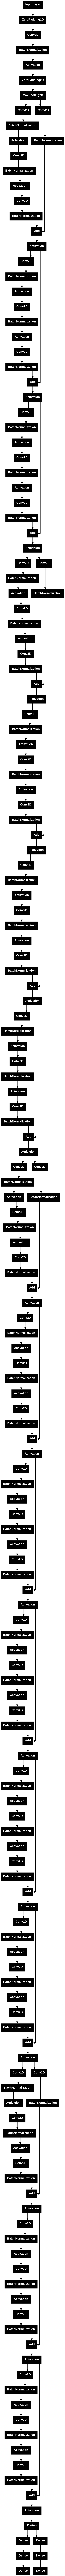

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [29]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'},
              loss_weights={'age':1,'gender':99})

In [32]:
def wrap_generator_output(generator):
    for x_batch, y_batch_list in generator:
        # y_batch_list will be a list like [age_labels_batch, gender_labels_batch]
        # Convert it to a dictionary matching model output names
        yield x_batch, {'age': y_batch_list[0], 'gender': y_batch_list[1]}

wrapped_train_generator = wrap_generator_output(train_generator)
wrapped_test_generator = wrap_generator_output(test_generator)

model.fit(wrapped_train_generator, batch_size=32, epochs=10, validation_data=wrapped_test_generator)

Epoch 1/10
   1011/Unknown 343s 325ms/step - age_loss: 15.7246 - age_mae: 15.7246 - gender_accuracy: 0.5072 - gender_loss: 1.1599 - loss: 130.5571

KeyboardInterrupt: 